## Feature Engineering & Model Testing

In [1]:
import pandas as pd
import numpy as np
from util.data_access import load_data
from util.preprocess import get_preprocessed_data, get_column_indices, train_test_split_by_step
from sklearn.model_selection import GridSearchCV
from util.tracking import get_metrics
from util import columns
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv()
SEED = 42
import datetime

import os
import mlflow
mlflow.set_tracking_uri('***REMOVED***')


EXPERIMENT_NAME = 'Fraud Model Feature Engineering Loop'

try:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
except Exception as e:
    print(e)
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

In [2]:
df_raw = load_data()

df = get_preprocessed_data(df_raw)

X_train, X_valid, y_train, y_valid = train_test_split_by_step(
    data=df,
    step='step',
    target='fraud',
    train_size=0.8
)


In [3]:
assert all(i in columns.NUMERICAL for i in columns.FRAUD_COMMITED_MEAN)

In [4]:
GRID_SEARCH = True
train_data = X_train.loc[:,columns.MODEL]
valid_data = X_valid.loc[:,columns.MODEL]
_cat_columns_idx = get_column_indices(train_data,columns.CATEGORICAL)

params = {
    'max_depth': 5,
    'n_estimators' : 200,
    'num_leaves': 40,
}
model = lgb.LGBMClassifier(
    **params,
    random_state=SEED,
    n_jobs=-1
)

if GRID_SEARCH:
    param_grid = {
        'max_depth': [-1, 3, 5, 10, 20, 30],
        'n_estimators': [100, 150, 200],
        'scale_pos_weight': np.arange(1,100,10),
        'num_leaves': np.arange(2,100,10),
        'learning_rate': np.logspace(-1,-4,5)
    }
    estimator = GridSearchCV(model,param_grid=param_grid,n_jobs=-1 )
    estimator.fit(train_data, y_train, categorical_feature=_cat_columns_idx)
    params = estimator.best_params_
else:
    estimator = model
    estimator.fit(train_data,y_train,categorical_feature=_cat_columns_idx)

/home/simontwo/zenml-competition/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [5]:
with mlflow.start_run(experiment_id='3') as run:
    mlflow.log_param('Train Data Dimension', train_data.shape)     
    mlflow.log_param('Train Target Bad Rate', y_train.mean())     
    mlflow.log_param('Valid Data Dimension', valid_data.shape)     
    mlflow.log_param('Valid Target Dimension', y_valid.mean())     

    mlflow.log_param('Model Type', model.__class__.__name__)
    y_pred_train = estimator.predict(train_data)
    y_pred_proba_train = estimator.predict(train_data)
    train_metrics = get_metrics(y_train,y_pred_train,y_pred_proba_train)

    for key, val in params.items():
        mlflow.log_param(key,val)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Train {key}', val)

    y_pred_valid = estimator.predict(valid_data)
    y_pred_proba_valid = estimator.predict(valid_data)
    train_metrics = get_metrics(y_valid,y_pred_valid,y_pred_proba_valid)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Validation {key}', val)

In [6]:
import shap
explainer = shap.TreeExplainer(model)
explain_data = train_data.sample(frac=0.1)
shap_values = explainer.shap_values(explain_data)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


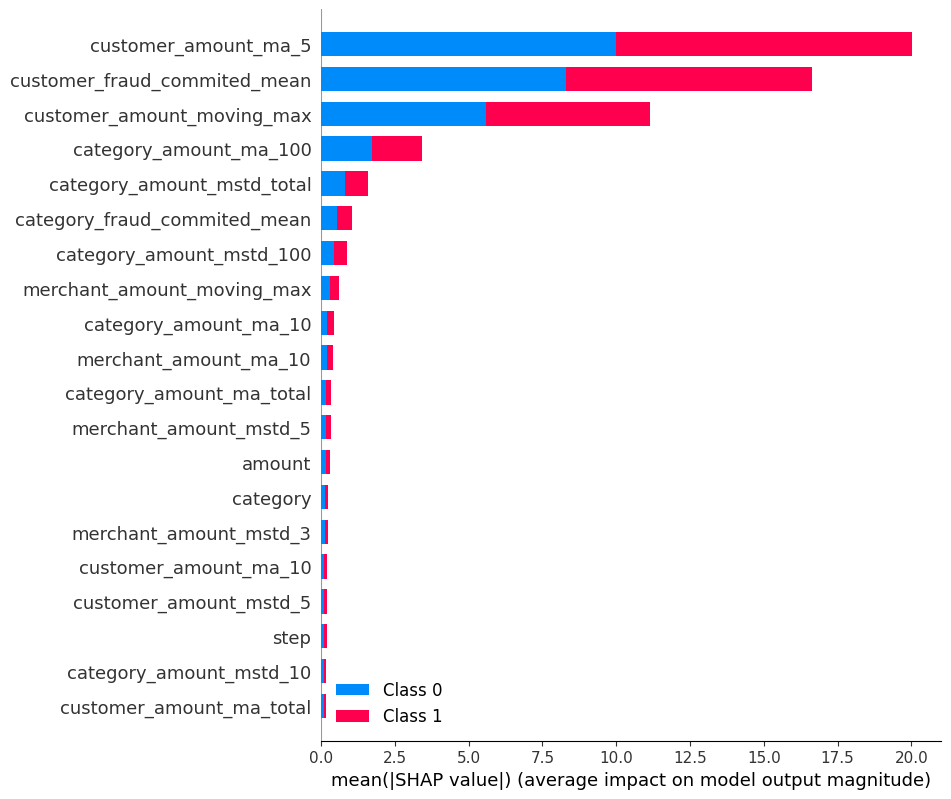

In [7]:
shap.summary_plot(shap_values, explain_data)

In [8]:
{
    col: f
    for col, f
    in zip(train_data.columns, model.feature_importances_)
}

{'step': 242,
 'amount': 348,
 'mean_category_amount_previous_step': 151,
 'customer_amount_ma_total': 169,
 'customer_amount_ma_10': 184,
 'customer_amount_ma_5': 211,
 'customer_amount_mstd_total': 147,
 'customer_amount_mstd_10': 110,
 'customer_amount_mstd_5': 150,
 'merchant_amount_ma_total': 136,
 'merchant_amount_ma_50': 81,
 'merchant_amount_ma_10': 135,
 'merchant_amount_ma_5': 86,
 'merchant_amount_ma_3': 136,
 'merchant_amount_mstd_total': 162,
 'merchant_amount_mstd_50': 96,
 'merchant_amount_mstd_10': 93,
 'merchant_amount_mstd_5': 190,
 'merchant_amount_mstd_3': 190,
 'category_amount_ma_total': 85,
 'category_amount_ma_100': 102,
 'category_amount_ma_10': 175,
 'category_amount_mstd_total': 144,
 'category_amount_mstd_100': 134,
 'category_amount_mstd_10': 172,
 'merchant_amount_moving_max': 203,
 'customer_amount_moving_max': 300,
 'category_amount_moving_max': 106,
 'customer_fraud_commited_mean': 263,
 'merchant_fraud_commited_mean': 100,
 'category_fraud_commited_mea